# Importing modules

In [ ]:
# Standard imports
import os
import pandas as pd
import numpy as np
import plotly.express as px
import plotly.graph_objs as go
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import trange
from colorama import Fore
from glob import glob
import json
from pprint import pprint
import time
import cv2

# For Data preparation
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import *
from sklearn.metrics import *

# For building models
import torch
from torch.utils.data import DataLoader, Dataset
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms, models


import warnings
warnings.filterwarnings("ignore")

# Config

In [ ]:
cfg = {}
cfg['train_dir'] = "../input/hackerearths-fast-furious-and-insured-challenge/dataset/trainImages"
cfg['test_dir'] = "../input/hackerearths-fast-furious-and-insured-challenge/dataset/testImages"
cfg['sample_csv'] = "../input/hackerearths-fast-furious-and-insured-challenge/dataset/sample_submission.csv"
cfg['test_csv'] = "../input/hackerearths-fast-furious-and-insured-challenge/dataset/test.csv"
cfg['train_csv'] = "../input/hackerearths-fast-furious-and-insured-challenge/dataset/train.csv"

pprint(cfg)

DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

print("\nCurrent Device", DEVICE)

# Loading data

We are given 2 tasks:
* Condition: Predict if the vehicle provided in the image is damaged or not
* Amount: Based on the condition of a vehicle, predict the insurance amount of the cars that are provided in
the dataset

In [ ]:
train_csv = pd.read_csv(cfg['train_csv'])
print("Length of Train Data: ", len(train_csv))
train_csv.sample(10)

Our output will be evaluated only for 50% of the test data while the contest is running. Once the contest is over, output for the remaining 50% of the data will be evaluated and the final rank will be awarded.

In [ ]:
test_csv = pd.read_csv(cfg['test_csv'])
print("Length of Test Data: ", len(test_csv))
test_csv.sample(10)

In [ ]:
sample_sub = pd.read_csv(cfg['sample_csv'])
print("Length of sample Data: ", len(sample_sub))
sample_sub

In [ ]:
train_csv['image_path'] = train_csv['Image_path'].apply(lambda x : cfg['train_dir']+"/"+x)
test_csv['image_path'] = test_csv['Image_path'].apply(lambda x : cfg['test_dir']+"/"+x)

In [ ]:
# Check: whether there are any duplicate images !
print(f"Total Images : ", len(os.listdir(cfg['train_dir'])))
print(f"Unique Images Count : ", len(train_csv.Image_path.unique()))

So, no duplicate images are present

# EDA

## First, lets set a fixed size for Images

In [ ]:
widths = []; heights = []
total_images = list(train_csv.image_path.values) + list(test_csv.image_path.values) 
for idx in trange(len(total_images), desc = "Collecting widths and heights...", bar_format="{l_bar}%s{bar:50}%s{r_bar}" % (Fore.CYAN, Fore.RESET), position = 0, leave = True):
    cur_path = total_images[idx]
    h, w, _ = cv2.imread(cur_path).shape
    widths.append(w)
    heights.append(h)
    
fig = px.histogram(widths)
fig.update_layout(title = 'Distribution of Image Widths', title_x = 0.5)
fig.show();

In [ ]:
fig = px.histogram(heights)
fig.update_layout(title = 'Distribution of Image heights', title_x = 0.5)
fig.show();

In [ ]:
"""
From the above plots, I concluded that
Image's width = 224
Image's height = 224

"""


cfg['image_size'] = 224
pprint(cfg)

## Lets see the distribution of Labels for our image data

In [ ]:
fig = px.histogram(train_csv, x = 'Condition', color = 'Condition', barmode = 'group')
fig.update_layout(
    title = 'Distribution of Image labels',
    title_x = 0.5
)

fig.show();

### Oberservation:
* Binary Classification problem
* Highly Imbalanced data
* Less amount of data
* Distribution - 0's = 99 & 1's = 1300

## Lets see the distribution of labels for our regression task

In [ ]:
fig = px.histogram(train_csv, x = 'Amount')
fig.update_layout(
        title_text = "Distribution of Amount",
        title_x = 0.5,
)
fig.show()

### Observation:
* Most of the values are constrained between (0, 11K)
* Some of the values, I guess is ambigous and we can remove them. Below table shows this:

| Range | Count |
| --- | --- |
| -1000 to -501 | 1 |
| 15K to 16K | 1 |
| 23K to 24K | 1 |
| 59K to 60K | 1 |

* But before removing them let's see whats the car's condition is for those labels

In [ ]:
# For Amount < 0
train_csv.loc[train_csv.Amount < 0]

In [ ]:
# For 15K < Amount < 16K
train_csv.loc[(train_csv.Amount > 15000) & (train_csv.Amount < 16000)]

In [ ]:
# For 20K < Amount < 24K
train_csv.loc[(train_csv.Amount > 20000) & (train_csv.Amount < 24000)]

In [ ]:
# For 59K < Amount < 60K
train_csv.loc[(train_csv.Amount > 59000) & (train_csv.Amount < 60000)]

## Lets see some of the images of both the classes

In [ ]:
condition_one = train_csv.loc[train_csv.Condition == 1]
condition_zero = train_csv.loc[train_csv.Condition == 0]


# For Condition == 1
plt.figure(figsize=(20,12))
for i in range(20):
    plt.subplot(5,4,i+1)
    
    img = cv2.imread(condition_one.image_path.values[i])
    img = cv2.resize(img, (cfg['image_size'], cfg['image_size']))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    plt.axis("off")
    plt.title('1')
    plt.imshow(img)
    
    
plt.tight_layout()
plt.show()

In [ ]:
# For Condition == 0
plt.figure(figsize=(20,12))
for i in range(20):
    plt.subplot(5,4,i+1)
    
    img = cv2.imread(condition_zero.image_path.values[i])
    img = cv2.resize(img, (cfg['image_size'], cfg['image_size']))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    plt.axis("off")
    plt.title('0')
    plt.imshow(img)
    
    
plt.tight_layout()
plt.show()

### Observations:
* Some of the images are basically noise for our training data e.g (0, 2) of 0 images, (1, 0) of 1 images etc..
* Some of them are rotated e.g (4, 1), (1, 0) & (4, 2) of 0 images etc..
* Some of them contains fine-grainied noise e.g (2, 2) of 0 images etc..

## Lets see how Insurance Company related to condition

In [ ]:
fig = px.histogram(train_csv,
                 x="Insurance_company",
                 color="Condition",
                )

fig.update_layout(
    template = 'ggplot2',
)
fig.show()

## Lets deal with NAN values

In [ ]:
train_csv.info()

In [ ]:
# We can see that some of the Columns have NAN values
# Lets count them

train_csv.isnull().sum()

### Dealing with NAN values of Min-Coverage and Max_Coverage


<h4>Before, we dive into it, let's understand the defination of Coverage.</h4>

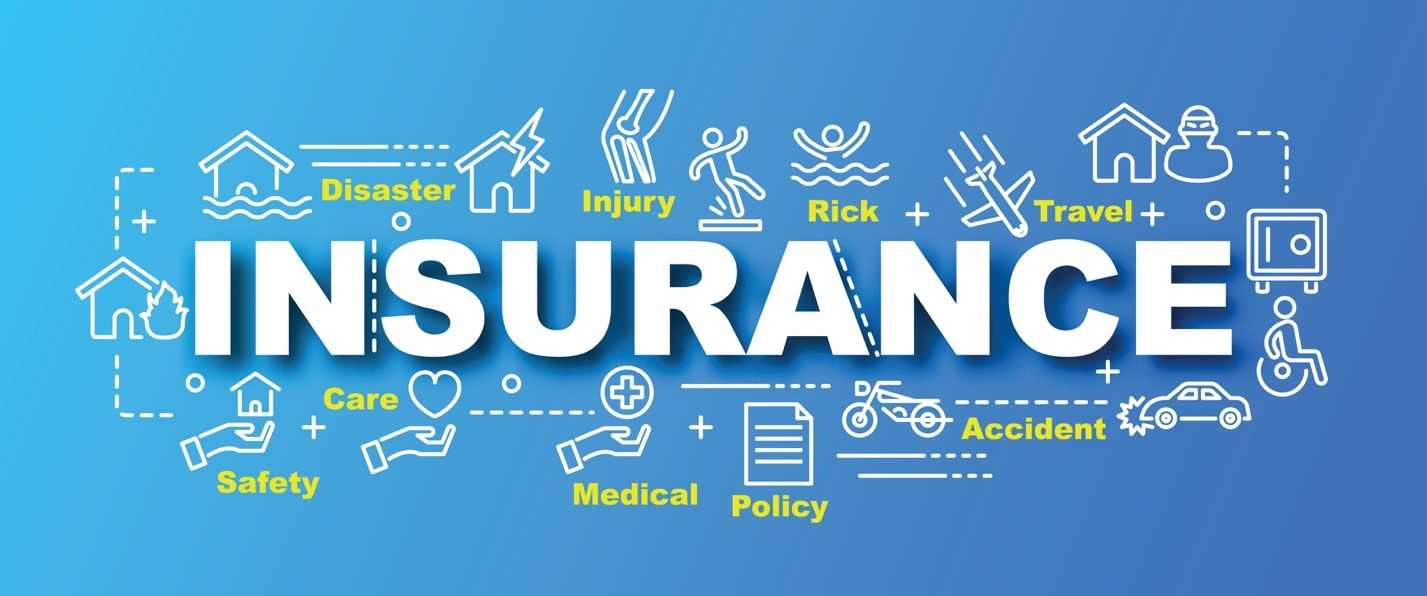

<p><strong style="color:green;">Insurance Coverage: </strong> Insurance coverage is the risk coverage for an individual by way of insurance services. An insurance cover helps an individual or an entity to protect themselves from unforeseen occurrences. It acts as a safety net protecting the policyholder and the family from unexpected situations.</p>
<p><strong style="color:tomato;">How to take insurance : </strong>To be covered under insurance, an individual has to pay a small fee monthly or annually for a certain period. In return, the insurance company will pay for the financial damages in case the person or object insured is damaged. By paying a small fee, one can transfer their financial risk to the insurance company.</p>

<p><strong style="color:cyan;">Types of Insurance :</strong></p>
<ul>
<li>Life Insurance</li>
<li>Health Insurance</li>
    <li style="color:#0099cc;"><em>Motor Insurance/ Auto Insurance</em></li>
<li>Travel Insurance</li>
<li>Property Insurance</li>
<li>Mobile Insurance</li>
<li>Cycle Insurance</li>
<li>Bite Size Insurance</li>
</ul>


<h4> Here we are dealing with motor life insurance, lets understand what it is</h4>
<h5 style="color:#0099cc;">Motor Insurance</h5>
<ul>
<li><em>Motor Insurance offers financial assistance in the event of accidents involving bike or car. Car insurance, two-wheeler insurance and commercial vehicle insurance are the different categories of motorised vehicles.</em></li> 

<li><p><em>Following are the benefits of motor insurance:</em>
<ul>
    <li>Avoids any traffic fines or other legalities</li>
<li>Meets all third-party liabilities. For example, an individual injures a person or damage someone’s property during an accident. The policy helps in addressing the monetary losses.</li>
<li>Provides financial assistance to repair one’s vehicle. Post an accident one doesn’t have to spend large sums of repairs. The policy will help in paying for the expenses.</li>
</ul></li></p>     
<li><em>Types of motor insurance</em>:
<ul>
<li><b>Third Party Liability:</b> This is the basic type of motor insurance. It is the mandatory requirement for all motorised vehicle owners as per the Motor Vehicles Act of 1988. These policies pay only for the financial liability to the third party due to the said mishap. It also ensures no legal hassles due to the accident. However, it doesn’t cover for vehicle damages of the policyholder.</li>
<li><b>Comprehensive Cover:</b> This is a more comprehensive plan than a third-party liability. It offers protection and security to the policyholder. In addition to covering for the third-party liabilities, the plan also covers the vehicle repair expenses. Furthermore, the plan also offers to pay out in case the vehicle sustains man made, natural calamities, riots or damage due to fire.</li>
<li><b>Own Damage Cover:</b> It is a specialised form of motor insurance. One is eligible to avail the plan only if they purchased a car or two-wheeler after September 2018. The vehicle has to be brand new and not a second hand one.</li></ul>
</li>

</ul>

In [ ]:
"""

Lets remove the rows having NAN values in Labels
We are removing these rows just for our regression task
We will still consider those rows for our classification task

"""

reg_train_csv = train_csv[~train_csv['Amount'].isnull()]
reg_train_csv.isnull().sum()

In [ ]:
# Lets see the NAN values
reg_nan_rows = reg_train_csv.loc[reg_train_csv['Cost_of_vehicle'].isnull()]
reg_nan_rows

In [ ]:
# Lets deal with rows having NAN values in cost_of_vehicle, min_coverage, max_coverage
reg_non_nan_rows = reg_train_csv.loc[~reg_train_csv['Cost_of_vehicle'].isnull()]
reg_non_nan_rows


The followings are the ways to deal with NAN values
- we can ignore these 87 rows
- we can find the minimum and maximum coverage by an insurance company and then set up a formula to calculate the Cost_of_vehicle
- we can simply put mean or median in the NAN values for respective column


In [ ]:
# Strategy to feel NAN values

reg_non_nan_rows['max_min_by_2'] = (reg_non_nan_rows['Max_coverage'] - reg_non_nan_rows['Min_coverage'])/2
reg_non_nan_rows['max_plus_min'] = reg_non_nan_rows['Max_coverage'] + reg_non_nan_rows['Min_coverage']
reg_non_nan_rows['times_max_plus_min'] = 4*reg_non_nan_rows['Max_coverage'] + reg_non_nan_rows['Min_coverage']

# Lets try to find which column has values close to Cost_of_vehicle
x_values = [d for d in range(1, 1302)]
fig = go.Figure()
fig.add_trace(go.Scatter(x=x_values, y=reg_non_nan_rows['Max_coverage'].values,
                    mode='lines+markers',
                    name='Max_coverage'))
fig.add_trace(go.Scatter(x=x_values, y=reg_non_nan_rows['Min_coverage'].values,
                    mode='lines+markers',
                    name='Min_coverage'))
fig.add_trace(go.Scatter(x=x_values, y=reg_non_nan_rows['max_min_by_2'].values,
                    mode='lines+markers', name='max_min_by_2'))
fig.add_trace(go.Scatter(x=x_values, y=reg_non_nan_rows['max_plus_min'].values,
                    mode='lines+markers', name='max_plus_min'))
fig.add_trace(go.Scatter(x=x_values, y=reg_non_nan_rows['Cost_of_vehicle'].values,
                    mode='lines+markers', name='Cost_of_vehicle'))
fig.add_trace(go.Scatter(x=x_values, y=reg_non_nan_rows['times_max_plus_min'].values,
                    mode='lines+markers', name='times_max_plus_min'))

fig.update_layout(
    title_text = "Line plots",
    title_x = .5,
    xaxis_title = "X_values",
    yaxis_title = "Values",
    height = 1024
)
fig.show()

We can see that 'times_max_plus_min' is very close to Cost_of_vehicle. We can put some cutOffs for this column so that we can control overshoot

In [ ]:
max_cost = train_csv['Cost_of_vehicle'].max()
max_cost

In [ ]:
reg_non_nan_rows['times_max_plus_min'] = reg_non_nan_rows['times_max_plus_min'].apply(lambda x: min(max_cost, x)) 

x_values = [d for d in range(1, 1302)]
fig = go.Figure()
fig.add_trace(go.Scatter(x=x_values, y=reg_non_nan_rows['Cost_of_vehicle'].values,
                    mode='lines+markers', name='Cost_of_vehicle'))
fig.add_trace(go.Scatter(x=x_values, y=reg_non_nan_rows['times_max_plus_min'].values,
                    mode='lines+markers', name='times_max_plus_min'))

fig.update_layout(
    title_text = "Line plots",
    title_x = .5,
    xaxis_title = "X_values",
    yaxis_title = "Values",
)
fig.show()
              
    

You can see both plots overlap over each other closely. So we can use the below formula NAN values in Cost_to_vehicle
> `Cost_to_vehicle_by_insurance_company = min(4*max_coverage_insurance_company + min_coverage_insurance_company, 53500.0)`

In [ ]:
# Lets find the max_coverage by Insurance company
reg_non_nan_rows.groupby('Insurance_company')['Max_coverage'].max()

In [ ]:
# Lets find the min_coverage by Insurance company
reg_non_nan_rows.groupby('Insurance_company')['Min_coverage'].max()

## Lets plot a scatterMatrix for our numerical columns

In [ ]:
index_vals = train_csv['Condition'].astype('category').cat.codes

fig = go.Figure(data=go.Splom(
                dimensions=[dict(label='Insurance_company',
                                 values=train_csv['Insurance_company']),
                            dict(label='Min_coverage',
                                 values=train_csv['Min_coverage']),
                            dict(label='Cost_of_vehicle',
                                 values=train_csv['Cost_of_vehicle']),
                            dict(label='Max_coverage',
                                 values=train_csv['Max_coverage']),
                            dict(label='Amount',
                                 values=train_csv['Amount'])],
                text=train_csv['Condition'],
                marker=dict(color=index_vals,
                            showscale=False, # colors encode categorical variables
                            line_color='red',
                            line_width=0.5)
                ))


fig.update_layout(
    title='ScatterMatrix of train_csv',
    title_x = 0.5,
    dragmode='select',
    height=900,
    hovermode='closest',
    template = "plotly_dark"
)

fig.show()


# Points to Note:
* The Dataset is highly imbalanced for image classification
* Majority of the Images are of Damaged cars
* Some of the images can be treated as noise for data
* Since we have a class imbalance problem with less data, I should suggest to use transfer learning. First, start with VGG16..then, I will go ResNeSt models
* In the regression task, we should not consider filling the NAN labels with mean and median because that would add error to my final results. Instead I will remove them.
* I have shown you a formula in which you can fill the NAN values in Cost_of_vehicle wrt to the max and min coverage by the Insurance company



<h2><em>If you like this notebook, please give a upvote to this notebook and dataset. Please be patient I will share you <strong style="color:cyan;">training</strong> and <strong style="color:green;">inference </strong>notebooks shortly...</em></h2>